# Assignment: Predict Oil Quality from Fluorescence Spectroscopy

### Course: Industrial and Societal Applications of Artificial Intelligence, Bachelor DSAI, SUPSI.

Name of the students: .... WRITE YOUR NAME HERE

##### Instructions

Write your name (or names if you are working in a group) in the cell above

Write your solution in the cell below the exercise. Some cell have been already partially completed to facilitate your work. If it is more conveninent for you, feel free to rewrite the entire cell/solution instead of using the pre-filled cell.


## Suggestions

Even if not always asked, whenever possible, print the final results to check correctness of the solution. For debugging and understanding, it is sometimes convenient also to print intermediate results.

Note: We do not care about your codes!! We only care about the final results!


## Delivery

The jupyter notebook should be executed from the beginning, running the notebook as follows: `Kernel -> Restart & Run All`. Check that the printed solutions are the ones you are expecting. 

We will run your notebook. If it breaks, we will evaluate your exercise only up to the break. 

Submission deadline: 25th of March, 2026


### Authors: Manas Mejari, Dario Piga. 

## Goal: Train a classifier to classify if an oil is EVOO (Extra-virgin Olive Oil) or non-EVOO.

**Inputs:** Excitation Emission maps (EEM), 

**Labels:** Absorption coefficients `Abs268` characterizing oil quality

# Description:

- We have a dataset for **24** different types of olive oil. The oils are denoted by letters 'A', 'B', ... 'X'.
- Each oil type is subjected to aging by artificial heating. We collect data at **9** aging steps: '0','1',...'9', with 0 denoting fresh oil, and n (with $1 \leq n \leq 9$) the aging step.


- Dataset consisits of
  
  -- Fluorescence data: **Excitation Emission Maps** for each oil type ('A',..'X') at each aging step ('0',...'9').
  
  -- Absorption data: **Absorption coefficients** for each oil type ('A',..'X') at each aging step ('0',...'9'). There are three absorption coefficients, but in this exercise we only focus on the coefficient: `Abs268`.
  
  
- Fluorescence data will be used to extract **input** features, Absorption coefficiet indicates if the oil is EVOO or not,
namely, **Abs268 <= 0.22** indicates that the oil is EVOO, otherwise it is non-EVOO.


In [1]:
# import necesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import seaborn as sn
from copy import copy
import os
import glob
import chardet #used only to reconstruct encoding of csv files
import csv
import string
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix

# Data for Fluorescence

Let us load the data set stored in the `flr_data.pkl` file. Save this data file in the same folder of your jupyter notebook. 
### Do not modify this code
The data is stored in the dictionary `dict_flr` which will be used in the rest of the notebook.

The keys of the `dict_flr` are the aging steps of the oil. Strings: '0','1',...'9'

In [2]:
# Read dictionary pkl file
import pickle
with open('flr_data.pkl', 'rb') as fp:
    dict_flr = pickle.load(fp)
    print('Fluorescence data loaded in a dictionary')

Fluorescence data loaded in a dictionary


In [3]:
dict_flr.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# Data for Absorption

Let us load the data set stored in the `abs_data.pkl` file. Save this data file in the same folder of your jupyter notebook. 

### Do not modify this code
The absorption coefficients data is stored in the dictionary `dict_abs` which will be used in the rest of the notebook.

The keys of the `dict_abs` are the aging steps of the oil. Strings: '0','1',...'9'


In [4]:
import pickle
# Read dictionary pkl file
with open('abs_data.pkl', 'rb') as fp:
    dict_abs = pickle.load(fp)
    print('Absorption data loaded in a dictionary')
dict_abs.keys()

Absorption data loaded in a dictionary


dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

### Function `get_data_flr` to obtain the `intensity` for a given `Aging_step` and given `Oil_type`
### Do not modify this code

In [5]:
def get_data_flr(Aging_step, Oil_type, Oil_sample = '1'):
    dict_as = dict_flr[Aging_step]
    flag = 0
    for key in dict_as.keys():
        if (key.find(Oil_type+Oil_sample) != -1):
            df_sample = dict_as.get(key)   # Selected data file
            
            # Select columns corrosponding to the Oil_type+Oil_sample
            
            # select emission wavelength from the dataframe
            select_col = [df_sample.columns.get_loc(col) for col in df_sample if col.startswith(Oil_type+Oil_sample)] # Emmision Wavelenght columns
            emission_range = df_sample.iloc[:,select_col]
            
            # select Intensity  from the dataframe
            select_col = [df_sample.columns.get_loc(col)+1 for col in df_sample if col.startswith(Oil_type+Oil_sample)]
            intensity = np.array(df_sample.iloc[:,select_col].astype(float))  # Intensities for different excitation wavelenghts
            
            
            # Remove noise and normalize the intensity
            #intensity = remove_noise(intensity, emission_range, 5)
            interval = 10.00
            excitation_range = np.arange(300.00,650.00,10) # Excitation range
            em_values = emission_range.values[:,0]
            em_values = em_values.astype('float64')
    
            intensity_new = np.zeros((len(em_values),len(excitation_range)))
    
            for ind in range(0, len(excitation_range)):
                mask = (em_values < excitation_range[ind]-interval) | (em_values > excitation_range[ind]+interval)
                mask = mask.astype(int)
        
                col_new = intensity[:,ind]*mask
                intensity_new[:,ind] = col_new
            
            selected_file = key
            flag = 1
            
    if (flag!=1):
        print ("Data frame not found")
    return emission_range, intensity_new

###  `get_data_abs()` to obtain the absorption coefficient `abs268` for a given `Aging_step` and a given `Oil_type`
### Do not modify this code

In [6]:
def get_data_abs(Aging_step, Oil_type):
    dict_as = dict_abs[Aging_step]
    flag = 0
    for key in dict_as.keys():
        if (key.find(Oil_type) != -1):
            df_sample = dict_as.get(key)   # Selected data file
            selected_file = key
            
            # Extract row corrosponding to the Oil type
            df_oil = df_sample.loc[df_sample['Oil_sample'].str.startswith(Oil_type)].copy()
            
            df_oil['Abs232']=df_oil['Abs232'].astype(float)
            df_oil['Abs264']=df_oil['Abs264'].astype(float)
            df_oil['Abs268']=df_oil['Abs268'].astype(float)
            df_oil['Abs272']=df_oil['Abs272'].astype(float)
            flag = 1
            
    if (flag!=1):
        print ("Data frame not found")
    return df_oil

In [7]:
Oil_sample = '1'   # Values between ['0','1', '2']          3  Oil samples
excitation_range = np.arange(300.00,650.00,10)             # Excitation range
excitation_range

array([300., 310., 320., 330., 340., 350., 360., 370., 380., 390., 400.,
       410., 420., 430., 440., 450., 460., 470., 480., 490., 500., 510.,
       520., 530., 540., 550., 560., 570., 580., 590., 600., 610., 620.,
       630., 640.])

### -----------------------------------------------------------------------------------------------------------------------------

#  Data Visualization
`get_data_flr(Aging_step, Oil_type)`: returns eem_wavelengths and intensity at a given aging step and for each oil type  

`get_data_abs(Aging_step, Oil_type)`: returns a dataframe containing absorption coefficients at a given aging step and for each oil type 

Example is given below.

*Make sure you understood the codes below, what the functions `get_data_flr` and `get_data_abs` take as inputs and what they return as outputs*.

In [8]:
Aging_step = '1'   # Values between ['0', '1', ..., '9']   10  Aging steps
Oil_type   = 'M'   # Values between ['A', 'B', ..., 'X']   24  Oil types

eem_range, intensity = get_data_flr(Aging_step, Oil_type)
df_abs = get_data_abs(Aging_step, Oil_type)


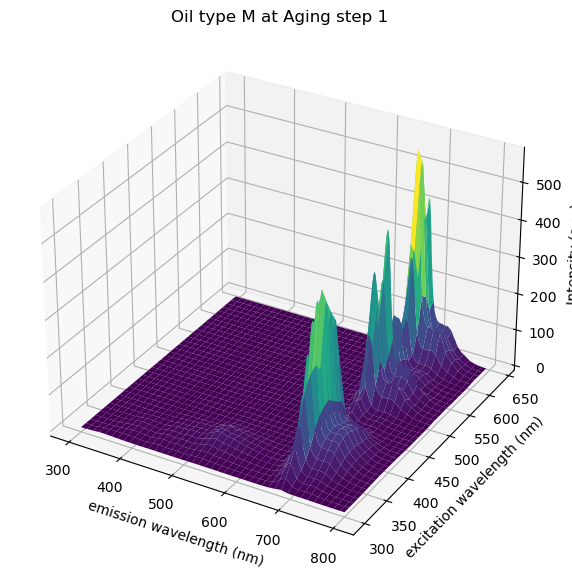

In [9]:
x = eem_range.iloc[:,0].values # emission wavelengths
x = x.astype(float)
    
Xgrid, Ygrid = np.meshgrid(excitation_range,x)

fig = plt.figure(figsize=(7,7))
ax  = plt.axes(projection='3d')

ax.plot_surface(Ygrid, Xgrid, intensity,cmap='viridis', edgecolor='none')

ax.set_xlabel('emission wavelength (nm)')
ax.set_ylabel('excitation wavelength (nm)')
ax.set_zlabel('Intensity (a.u.)')

ax.set_title('Oil type '+ Oil_type + ' at Aging step '+ Aging_step)
plt.show()

In [10]:
df_abs = get_data_abs(Aging_step, Oil_type) # In this exercise we are interested only in Abs268
df_abs

,Oil_sample,Abs232,Abs264,Abs268,Abs272
2,M0,2.0971,0.12,0.1131,0.1087


# Exercise 1: Visualize fluorescence data: Excitation-Emission Maps (EEM)

# 1.1 Plot the EEM map for oil type ``M' at aging steps `0' (fresh oil), '5' and '9'.  

We expect plots like the ones shown here:

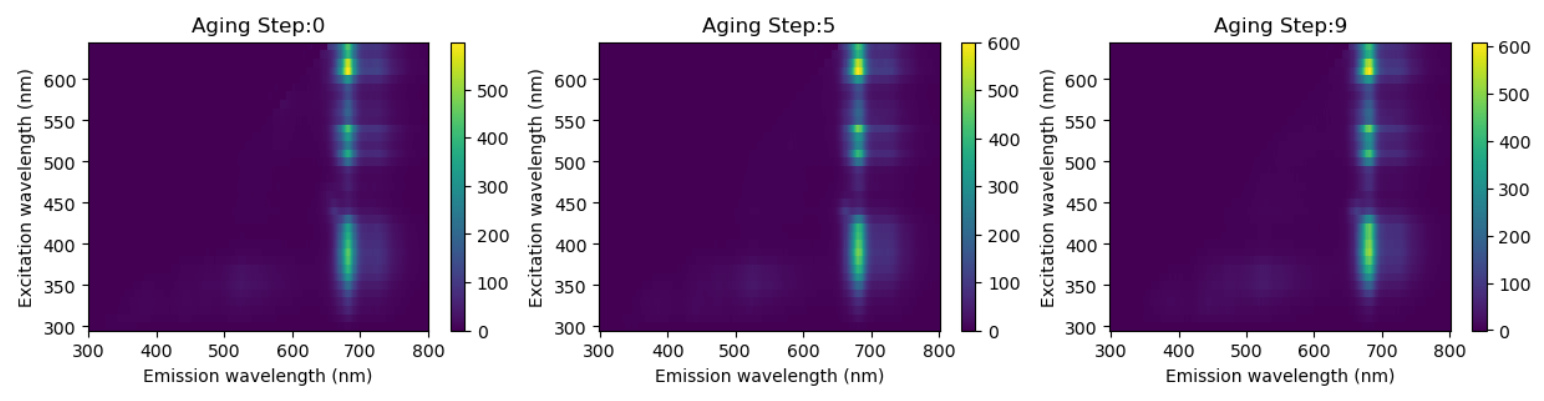

Hints: 

1. see the excitation and emission wavelengths, along with associated intensity, through the command: eem_range, intensity = get_data_flr(Aging_step, Oil_type, '1')

2. Note that `eem_range, intensity = get_data_flr(Aging_step, Oil_type)` 
   returns `intensity`, an arrray of shape '(251,35)'.

3. Each column corresponds to the intensity at a particular excitation wavelength. For e.g., `intensity[:,0]`: intensity at    excitation wavelength 300.00 (nm); `intensity[:,1]`: intensity at excitaion wavelenth 310.00 (nm) and so on.
 
4. You can use the function `pcolormesh` function from matplotlib library to create the plots above.


In [11]:
# Write your solution here:
...

### 1.2 Plot the intensity for oil_type ``M" at the excitation wavelenght = 480 nm, at aging steps '0' ,'5' '9'

### Hint:
1. There are **35** excitation wavelenths varying from **[300.00, 310, ...,640]**. Chosse the index corresponding to the **480 nm**.
2. If you want to select automatically an appropriate column of the intensity array (e.g. corresponding to the index of **480 (nm)**), you can define the following array  `excitation_range = np.arange(300.00,650.00,10)`, and you may use `np.where()` function to find the index corresponding to the index 480.00 nm.

We expect a plot like: 
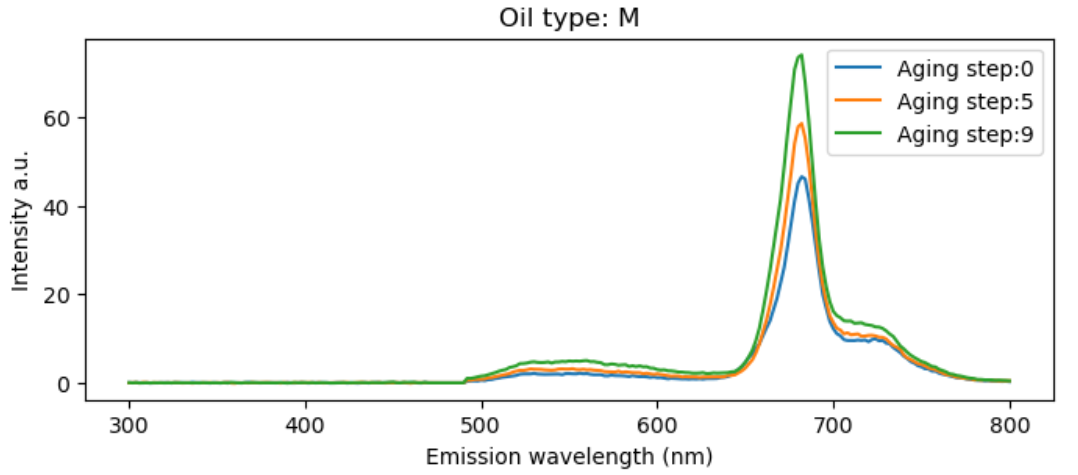

In [12]:
# Write your solution here
...

## 1.3 Plot the intensity for **all** oil types ['A','B',..,'X'] at the excitation wavelenght = 480 nm, at aging step '0' and '9'
**Hints**: 
1. Create **24** subplots: 1 for each Oil type.
2. For a given oil type, plot the intensity at aging step 0 and aging step 9 in the **same** subplot, namely the y-axis of the subplot is the intensity and x-axis is the emission wavelenth.


In [13]:
# Write your solution here
...

# 1.4 Visualize the absorption coefficients
## Plot the absorption coefficient **Abs268** for all oil types  for all aging steps '0','1',...'9' 

You should generate 24 subplots (one for each oil type). On the y-axis plot the value of abs268; in the x-axis plot the aging steps. 

### Hints: 

1.`df_abs = get_data_abs(Aging_step, Oil_type)` returns the data frame containing absorption coefficients 
   for a specified aging step and oil type.
   
2. Use the command `df_abs.iloc[0]['Abs268']` to extract the value of the absorption coefficient **Abs268**  

In [14]:
# Write your solution here
...

# Excercise 2: Computing the relative error and find the two most significant excitation wavelengths 

### 2.1 Write a function `compute_relative_error()` to compute the relative errors between two intensities at a given excitation wavelength. 




1.  Your function should take 4 arguments `compute_relative_error(aging_fresh, aging_latest, Oil_type, excitation_wavelength)` and return a single scalar relative error.

The first intensity is obtained from the EEM map at the aging step  = `aging_fresh` = '0'.  In the rest of the excersie the relative error is always computed w.r.t. fresh oil. Thus, always set `aging_fresh` = '0'. 

The second intensity is obtained from the EEM map at the aging step = `aging_latest` ( a string from '0' to '9') 

2. Relative error between the two vectors $a$, $b$ is calculated as $\frac{\| a-b\|}{\| a\|}$ where $\|a\|$ denotes the norm of the vector. You may use the function `np.linalg.norm()` to compute the vector norm.

4. Refer to a subplot you obtained in the exercise **1.3**. Basically you want to compute the relative error between the two curves (actually, vectors).

In [4]:
# write your solution here (TO BE COMPLETED)

def compute_relative_error(aging_fresh, aging_latest, Oil_type, excitation_wavelength):
    
    ...
    
    return rel_error

# Example: Compute relative error (w.r.t. fresh oil) at aging step 9, for oil type A, at excitation_wavelength 480 nm

rel_error = compute_relative_error(aging_fresh = '0', aging_latest = '9', Oil_type = 'A', excitation_wavelength = 480)


### 2.2 Compute the relative error between the intensities at Aging Step 0 and Aging Step 9, for each excitation wavelength [300.00, 310.00..., 650.00] and for each Oil type. 
 ***Hint***

1. Using the function from **Ex 2.1** :Create a table of relative errors as follows: **35** rows corresponding to the excitation wavelengths and **24** columns corresponding to each oil type.

We expect a table like the one in the following, containing the relative errors (instead of the 0s) with as many rows as the number excitation wavelengths and 24 columns

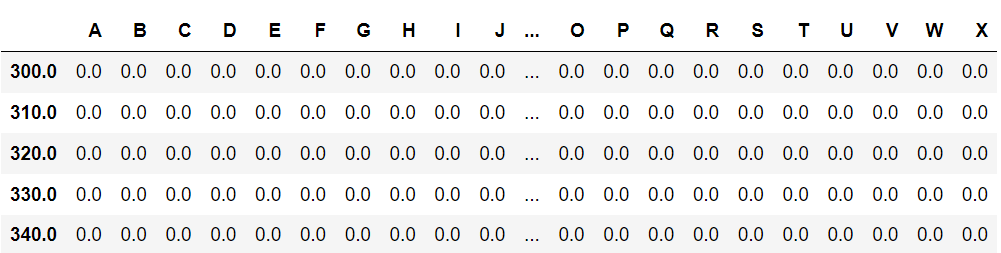


In [ ]:
# write your solution here.
...

### 2.3 Compute the average relative error over oil types (averge over the columns) and find out the two most significant excitation wavelengths having the highest relative error.

In [ ]:
# Write your solution here
...

# Exercise 3: Input-Ouput dataset for  training a classifier

### 3.1 Create a dictionary of input-output data

1. Compute the relative errors only at the two most significant excitation wavelengths found in the exercise **2.3**. 

2. Creat a dictionary `IO_data` as follows: The key of the dictionary is Oil_type (string 'A',..'X') and the corrsponding value is a list with the following 3 elements:
    
    IO_data[Oil_type][0]: Relative errors over all aging steps for the first excitation wavelength.  (array-like with 10 elements:one for each aging step including '0' aging step)
    
    IO_data[Oil_type][1]: Relative errors over all aging steps for the second excitation wavelength (array-like with 10 elements:one for each aging step including '0' aging step)
    
    IO_data[Oil_type][2]: `Abs268` coefficient over all aging steps (Output labels)
    

Note that the relative error at aging step '0' will be always 0.0.



 


In [ ]:
# Write your solution here
...

### 3.2 From the `IO_data` dictionary created in **Ex 3.1** plot the following:


1. First subplot:
Given the most significant excitation wavelength
plot aging steps (x-axis) vs relative error (y-axis) for all oil types. 
2. Second subplot:
plot Aging steps (x-axis) vs Abs268 (y-axis) for all oil types.

We expect plots like the one shown below:

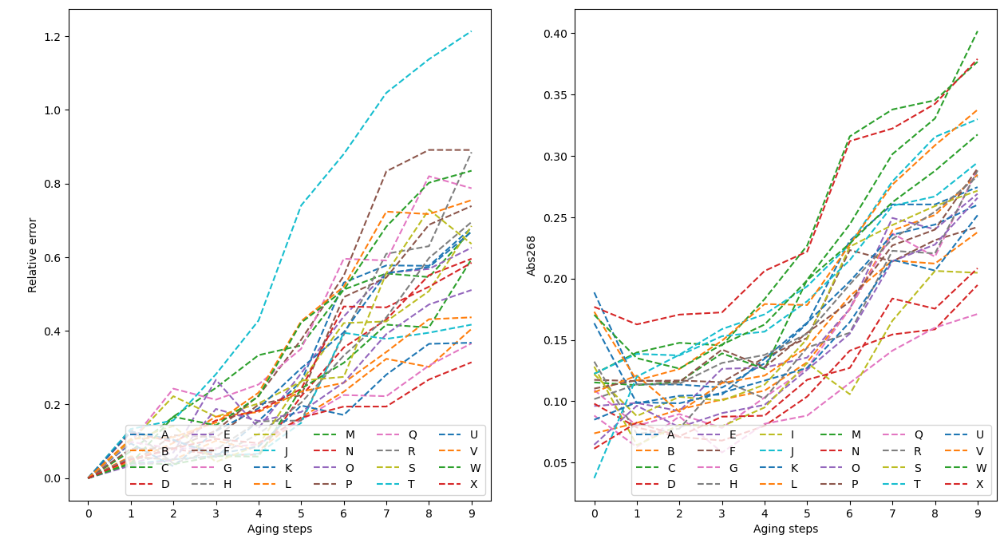

In [ ]:
# Write your solution here
...

# Exercise 4: Training a random forest classifier and leave-one-out validation
You have the training data ready for the classifier: IO_data

Input features: relative errors (IO_data[:][0], IO_data[:][1]) and intial condition of Abs268 (intial values IO_data[:][2])

Output labels: Class labels: {0,1}
**1** if Abs268 <= **0.22**, (Oil is  an EVOO)
**0** if Abs268 > **0.22** , (Oil is non-EVOO)

**Proceduce for leave-one-out cross validation:**
1. We use training data from aging steps **'3'** to **'9'** for all oil types, leaving out one oil type.  Thus in total we have 7*(24-1) training points.

2. Create a **confusion matrix** to asses the performance:
   - Consider only the last aging step of the left out oil.
   - Check if at the last aging step the left out oil is classfied as EVOO or not by your classifier.
   - Check if at the last aging step, the oil is EVOO or not based on the value of Abs268.

   


**Note that we train 24 random forest classifiers and each one is tested for one oil type.**

For Example: 

1st iteration:  Train a classifier using oils 'B'...'X'. Validate on oil 'A' at the last aging step.

2nd iteration:  Train a classifier using oils 'A', 'C'...'X'. Validate on oil 'B' at the last aging step.

24th iteration: Train a classifier for oils 'A', 'B'...'W'. Validate on oil 'X' at the last aging step.

The confusion matrix should be created based on these 24 preditions





### The function `data_IO_combined(IO_data, selected_oils, start_AS, end_AS, fresh_step)` below gives the input features X and output labels for a RF classifier in numpy arrays.
`X_data, Y_class = data_IO_combined(IO_data, selected_oils, start_AS, end_AS, fresh_step)`


Use this function in the leave-one-out cross-validation.

**function returns:**

X_data  : numpy array of input features: relative errors at ev1 and ev2, and value of 'Abs268' for fresh oil

Y_class : Integer class labels {0,1}. 


**function arguments:**

IO_data : dictionary created according to the **exercise 3.1**

selected_oils: list of strings, e.g. in the first fold: selected_oils = ['B',...'X']

start_AS: starting aging step used for training, in our case, start_AS= 3

end_AS  : last aging step used for training, in our case, end_AS = 9

fresh_step: intital ageing step for the absorption coefficient, consider fresh_step=1



In [2]:
# do not modify this code.
def data_IO_combined(IO_data, selected_oils, start_AS=3, end_AS=9, fresh_step=1):
    # Preparing input data
    Y_list =[]
    count = 0

    for key in selected_oils:
        inp_data_med = IO_data[key][0]   # Relative error for significant excitation 
        inp_data_sel = IO_data[key][1]   # Relative error for second significant excitation  excitation wavelength
    
        out_data = IO_data[key][2]   # Abs coeff 268
    
        for val1,val2 in zip(inp_data_med[start_AS:end_AS+1],inp_data_sel[start_AS:end_AS+1]):
            temp = np.array([[val1, val2, out_data[fresh_step]]])
            if count >=1:
                X_list = np.concatenate((X_list,temp), axis =0)
            else:
                X_list = temp
        
            count = count +1
    
        Y_list.append(out_data[start_AS:end_AS+1])


    X_data = X_list
    Y_data = np.array(Y_list)
    Y_reg  = np.reshape(Y_data, (-1, 1))
    
    Y_class = Y_reg<= 0.22
    Y_class = Y_class.astype('int')
    
    return X_data, Y_class

### The cell below gives an example of the training data: input X_data and output Y_class  when the left out oil to be tested is Oil_type 'D'.

Note: Use the dictionary `IO_data` at Exercise 3. 

In [3]:
start_AS = 3
end_AS   = 9
fresh_step = 1 

alphabet_string = string.ascii_uppercase
Oil_brands = list(alphabet_string[0:24]) # list of A to X

Oil_type = 'D'

# leave one out
selected_oils = [x for x in Oil_brands if x!=Oil_type]
print(f'Selected oils for training:  {selected_oils}')

X_data,  Y_class = data_IO_combined(IO_data, selected_oils, start_AS, end_AS, fresh_step)

print(X_data.shape)
print(Y_class.shape)

print(X_data)
print(Y_class)

NameError: name 'string' is not defined

### 4.1: Train a random forest classifier with leave-one-out cross validation

We expect 24 classifiers, each one trained on 23 oil types and tested on the remaining one.

Validate the performance plotting the confusion matrix

In [ ]:
# Write your solution here
...
